In [1]:
import tensorflow as tf

In [2]:
# 输入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# define some parameters
learning_rate = 0.001
training_iters = 2000
batch_size = 128
display_step =10
n_input = 784 #(28*28*1)
n_classes = 10
dropout = 0.75
# 
x = tf.placeholder(tf.float32,[None,n_input])
y = tf.placeholder(tf.float32,[None,n_classes])
keep_prob = tf.placeholder(tf.float32)

In [4]:
# define the Alexnet
#  functions
def conv2d(name,x,W,b,strides=1):
    x= tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding="SAME")
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x,name=name)

def maxpool2d(name,x,k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding="SAME",
                          name=name)

def norm(name,l_input,lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0,
                     beta=0.75, name=name)

In [5]:
# define all weights
weights={
    'w1':tf.Variable(tf.random_normal([11,11,1,96])),
    'w2':tf.Variable(tf.random_normal([5,5,96,256])),
    'w3':tf.Variable(tf.random_normal([3,3,256,384])),
    'w4':tf.Variable(tf.random_normal([3,3,384,384])),
    'w5':tf.Variable(tf.random_normal([3,3,384,256])),
    'w6':tf.Variable(tf.random_normal([2*2*256,1024])),
    'w7':tf.Variable(tf.random_normal([1024,1024])),
    'w8':tf.Variable(tf.random_normal([1024,n_classes])),}
#define all biases
biases = {
    'b1': tf.Variable(tf.random_normal([96])),
    'b2': tf.Variable(tf.random_normal([256])),
    'b3': tf.Variable(tf.random_normal([384])),
    'b4': tf.Variable(tf.random_normal([384])),
    'b5': tf.Variable(tf.random_normal([256])),
    'b6': tf.Variable(tf.random_normal([1024])),
    'b7': tf.Variable(tf.random_normal([1024])),
    'b8': tf.Variable(tf.random_normal([n_classes]))
}

In [6]:
# define the Alexnet
# 5 conventional layers and 3 fully connected layers
def alexNet(x,weights,biases,dropout):
    x = tf.reshape(x,shape=[-1,28,28,1]) # Reshape the picture
    # C1
    conv1 = conv2d('conv1',x,weights['w1'],biases['b1'])
    # pool
    pool1 = maxpool2d('pool1',conv1,k=2) # (28//2=14)
    # norm
    norm1 = norm('norm1',pool1,lsize=4)
    
    # C2
    conv2 = conv2d('conv2',norm1,weights['w2'],biases['b2'])
    # pool
    pool2 = maxpool2d('pool2',conv2,k=2) # (14//2=7)
    # norm
    norm2 = norm('norm2',pool2,lsize=4)
    
    # C3
    conv3 = conv2d('conv3',norm2,weights['w3'],biases['b3'])
    # pool
    pool3 = maxpool2d('pool3',conv3,k=2) # (7//2=3.5+1=4)
    # norm
    norm3 = norm('norm3',pool3,lsize=4)
    
    # C4
    conv4 = conv2d('conv4',norm3,weights['w4'],biases['b4'])
    
    # C5
    conv5 = conv2d('conv5',conv4,weights['w5'],biases['b5'])
    # pool
    pool5 = maxpool2d('pool5',conv5,k=2) # (4//2=2)
    # norm
    norm5 = norm('Norm5',pool5,lsize=4)
    
    ## reshape, some wrong here,change the shape to 32,not 128 why?
    xx = tf.reshape(norm5,[-1,weights['w6'].get_shape().as_list()[0]]) ###?
#     xx = tf.reshape(norm5,[-1,4*4*256])
    # FC1
    fc1 = tf.add(tf.matmul(xx,weights['w6']),biases['b6'])
    fc1 = tf.nn.relu(fc1)
    # dropout
    fc1 = tf.nn.dropout(fc1,dropout)
    
    # FC2
    fc2 = tf.reshape(fc1, [-1, weights['w7'].get_shape().as_list()[0]])
    fc2 = tf.add(tf.matmul(fc1,weights['w7']),biases['b7'])
    fc2 = tf.nn.relu(fc2)
    # dropout
    fc2 = tf.nn.dropout(fc2,dropout)
    
    # FC3
    fc3 = tf.add(tf.matmul(fc2,weights['w8']),biases['b8'])
    
    return fc3
    


In [7]:
# build the model 
pred = alexNet(x,weights,biases,keep_prob)

# cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred,
                                                                 labels=y))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# evaluation 
corrected_pred = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(corrected_pred,tf.float32))

# store
Loss = [];
Acc = [];

In [9]:
init = tf.global_variables_initializer()

import time
with tf.Session() as sess:
    sess.run(init)
    step = 1
    print("Optimization start:")
    while step*batch_size < training_iters*10:
        t1 = time.time();
        batch_x,batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y,keep_prob:dropout})
        if step % display_step ==0:
            loss, acc =sess.run([cost,accuracy],feed_dict={x:batch_x,y:batch_y,
                                                           keep_prob:1.})
            Loss.append(loss)
            Acc.append(acc)
            t2 = time.time()-t1
            print("Iter "+str(step*batch_size)+", Minibatch Loss= "+
                 "{:.6f}".format(loss)+", Training Accuracy= "+
               "{:.5f}".format(acc)+", Training time: {:.2f}".format(t2))
        step +=1
    print("Optimization Finished!")
            

Optimization start:
Iter 1280, Minibatch Loss= 6343.009277, Training Accuracy= 0.30469, Training time: 3.96
Iter 2560, Minibatch Loss= 3322.373047, Training Accuracy= 0.44531, Training time: 4.28
Iter 3840, Minibatch Loss= 1849.596924, Training Accuracy= 0.60156, Training time: 4.00
Iter 5120, Minibatch Loss= 639.389954, Training Accuracy= 0.83594, Training time: 3.99
Iter 6400, Minibatch Loss= 790.622253, Training Accuracy= 0.81250, Training time: 4.03
Iter 7680, Minibatch Loss= 974.000854, Training Accuracy= 0.80469, Training time: 4.07
Iter 8960, Minibatch Loss= 713.555115, Training Accuracy= 0.82812, Training time: 3.96
Iter 10240, Minibatch Loss= 774.744263, Training Accuracy= 0.78906, Training time: 3.94
Iter 11520, Minibatch Loss= 792.385193, Training Accuracy= 0.80469, Training time: 3.96
Iter 12800, Minibatch Loss= 532.457031, Training Accuracy= 0.82031, Training time: 3.96
Iter 14080, Minibatch Loss= 437.048218, Training Accuracy= 0.88281, Training time: 4.33
Iter 15360, Mini

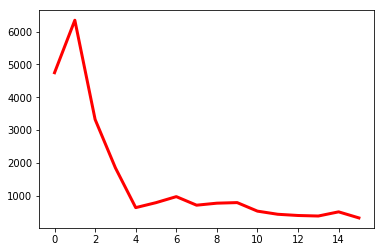

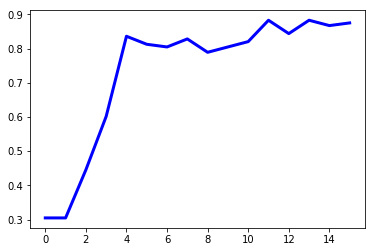

In [10]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(range(len(Loss)),Loss,color='r',lw=3)
plt.xlabel('Eopch')
plt
plt.figure(2)
plt.plot(range(len(Acc)),Acc,color='b',lw=3)
plt.show()